In [1]:
from numba import jit
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import scipy.io as sio
from Bio import SeqIO
import yfinance as yf
import numpy as np
from numba import njit,jit
import sys
from matplotlib import ticker
import matplotlib.pyplot as plt
from scipy.special import betainc, hyp2f1, gamma
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
font = {'size': 30, 'weight':'normal'}
plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "text.latex.preamble": r"\usepackage{amssymb}",
})
rng = np.random.default_rng(seed=42)
colors = [['blue',"slateblue"], ['darkgoldenrod', "goldenrod"], ['red', "indianred",], ['olivedrab', "yellowgreen"], ['plum',"pink"], ['black','dimgray'], ['orangered','coral'] ]

locminx = ticker.LogLocator(base=10.0,subs=np.linspace(0,1,11),numticks=12)
locmajx = ticker.LogLocator(base=10,numticks=12) 
locminy = ticker.LogLocator(base=10.0,subs=np.linspace(0,1,11),numticks=12)
locmajy = ticker.LogLocator(base=10,numticks=12) 
from collections import Counter

def modlin(x,a,b):
    return a*x+b

def finv(x,a):
    return a/x

@jit(nopython=True)
def Splitt(V):
    T=[]
    m,M, pos=min(V[0],V[1 ]),max(V[0],V[1]),0
    if V[1]>V[0]:
        pos=1
    else:
        pos=-1
    for k in range(2,len(V)):
        if V[k]>M and pos==1:
            T.append(0)
            pos=1
        elif V[k]<m and pos==-1:
            T.append(0)
            pos=-1
        elif V[k]>M and pos==-1:
            T.append(1)
            pos=1
        elif V[k]<m and pos==1:
            T.append(1)
            pos=-1
        M=max(V[k],M)
        m=min(V[k],m)
    return T

@jit(nopython=True)
def Splitt_alt(V0):
    # center the trajectory at its origin
    V=V0-V0[0]
    T=[]
    m,M, pos=min(V[0],V[1 ]),max(V[0],V[1]),0
    if V[1]>V[0]:
        pos=1
    else:
        pos=-1
    seen_zero = 0
    for k in range(2,len(V)):
        # if we crossed zero, we are on opposite side from the last visited side pos
        if (not seen_zero) and (pos*V[k]<0):
            seen_zero=1
        if V[k]>M:
            T.append(seen_zero)
            seen_zero = 0
            pos=1
        if V[k]<m:
            T.append(seen_zero)
            seen_zero = 0
            pos=-1
        
        M=max(V[k],M)
        m=min(V[k],m)
    return T

# Microspheres
See paper Nature Comm, data given by someone to thank for (see Ref 26),  D. Krapf, M. Weiss, F. Taheri and
C. Selhuber-Unkel

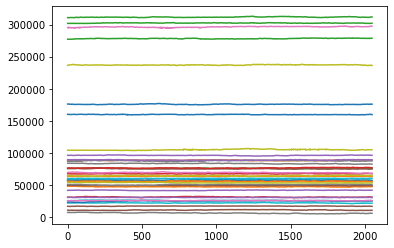

In [5]:
px=np.loadtxt('Data/Trajectories_beads_agarose.txt')
Traj=np.array([px[:,k] for k in range(len(px[0]))])

for k in range(len(Traj)):
  plt.plot(Traj[k])
plt.show()
H=0.43

40
2049


(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

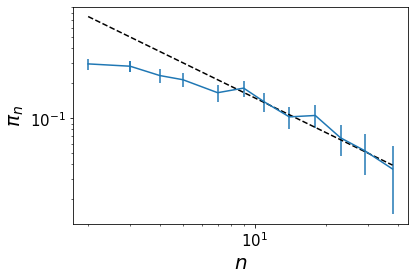

In [8]:
T=[]
Max=0

epochs=20 #20 equally spaced start for the trajectory
print(len(Traj))  #40 trajectories
print(len(Traj[0])) #Length of trajectory

for m in range(epochs-1): 
  for k in range(len(Traj)):
    window=len(Traj[k])//epochs
    #print(window)
    Size=Splitt(Traj[k][window*m:])
    T.append(Size[:])
    Max=max(len(Size),Max)
    
Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
        
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(0.25,np.log10(Max)-0.1,15))
Ind=Ind[p[Ind]>yerr[Ind]*1.5]

plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind])
plt.plot(n[Ind],1.5/n[Ind],'--k')


plt.semilogx()
plt.semilogy()

plt.ylabel(r'$\pi_n$',fontsize=20)
plt.xlabel(r'$n$',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

# DNA RW HUMBMYH7
From the GenBank website, look at Nature Commun paper for more on this dataset

M57965.2


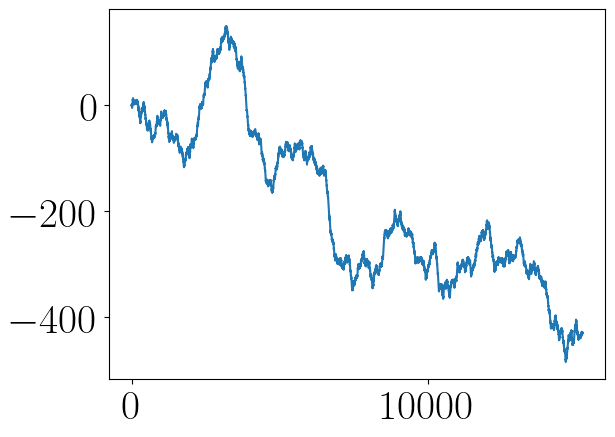

In [257]:
for seq_record in SeqIO.parse("Data/HUMBMYH7.gb","genbank"): 
    print(seq_record.id)
    #print(seq_record.seq)
    #print(len(seq_record.seq))
u=[0]
st=str(seq_record.seq)
for s in st:
    # if s in ['A','G']:
    #     u.append(u[-1]-1.)
    # else:
    #     u.append(u[-1]+1.)
    if s in ['C']:
        u.append(u[-1]-1.)
    elif s in ['G']:
        u.append(u[-1]+1.)

Values=np.array(u)

X=np.arange(len(Values))


a,b=curve_fit(modlin,X,Values)[0]
a,b=0,0

# Values=Values-modlin(X,a,b) #Remove the bias

plt.plot(X,Values)
plt.show()

18
18
[0.45196917] [[0.00038559]]


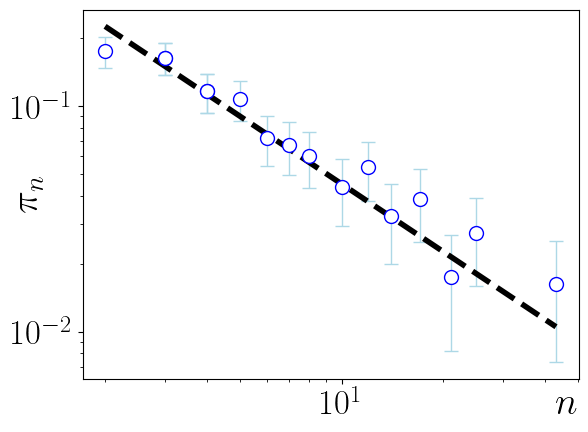

In [260]:
T=[]
Max=0

T=[]
epochs=800
print(len(Values)//epochs)
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
    Max=max(len(Size),Max)
    T.append(Size[:])

    Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.2,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]
fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)

A,var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
print(A,var)
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)

plt.semilogx()
plt.semilogy()
plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/GenomicBMYH7.pdf', dpi=600, bbox_inches='tight')

# DNA RW HUMTCRA
From the GenBank website, look at Nature Commun paper for more on this dataset

M94081.1


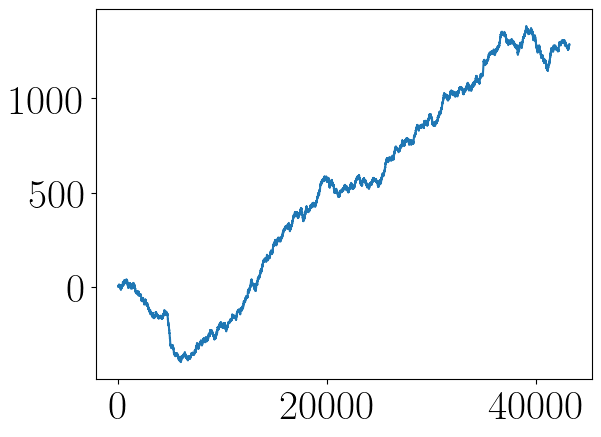

In [2]:
for seq_record in SeqIO.parse("Data/HUMTCRADCV.gb","genbank"): #"HHUMHBB.gb","genbank"
    print(seq_record.id)
    #print(seq_record.seq)
    #print(len(seq_record.seq))
u=[0]
st=str(seq_record.seq)
for s in st:
    # if s in ['A','G','H','X']:
    #     u.append(u[-1]-1.)
    # else:
    #     u.append(u[-1]+1.)
    if s in ['C']:
        u.append(u[-1]-1.)
    elif s in ['G']:
        u.append(u[-1]+1.)

Values=np.array(u)


X=np.arange(len(Values))

a,b=curve_fit(modlin,X,Values)[0]
a,b=0,0

Values=Values-modlin(X,a,b)

plt.plot(Values)
plt.show()

53
0.4977990779435818 [ 2  3  3  4  5  6  8  9 12 15 18 23 29 36]


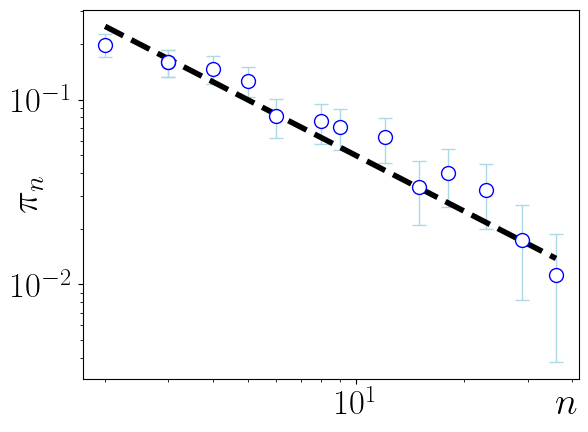

In [3]:
Max=0
T=[]
epochs=800
# print(len(Values)//epochs)
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
    # print(len(Size),len(Values[k*window:]))
    Max=max(len(Size),Max)
    T.append(Size)
    
Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]
fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)

A = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])[0][0]
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,  n[Ind])

#plt.errorbar(n,p,yerr=yerr)
#plt.plot(n,1/n,'--k')

plt.semilogx()
plt.semilogy()

# ax.text(8, 0.1, rf'DNA RW HUMTCRA', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25)
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/GenomicHUMTCRA.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Intra-cellular vacuoles in Amoeba
See paper Nature Comm, data given by someone to thank for (see Ref 26),  D. Krapf, M. Weiss, F. Taheri and
C. Selhuber-Unkel

In [5]:
Traj=[[]]
for s in ['1','2a','3','4','5','7','8','9','11']:
  test=sio.loadmat('Data/Amoeba_Data/Amoeba'+s+'_vac_tracks.mat')
  X=test['track4xml'][:,0]
  Y=X=test['track4xml'][:,1]  
  T=test['track4xml'][:,4]
  Traj[-1].append(X[0])
  for k in range(1,len(X)):
        if T[k]!=T[k-1]:
            Traj.append([])
        Traj[-1].append(X[k])
  Traj.append([])
  Traj[-1].append(Y[0])
  for k in range(1,len(Y)):
        if T[k]!=T[k-1]:
            Traj.append([])
        Traj[-1].append(Y[k])
        
Trajf=[]
for p in Traj:
    if len(p)>2048:
        Trajf.append(np.array(p[:2048][:])) #Select only trajectories long enough
Traj=Trajf[:]
P=np.array(Traj) # In this dataset: multiple trajectories

205
2048
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
4

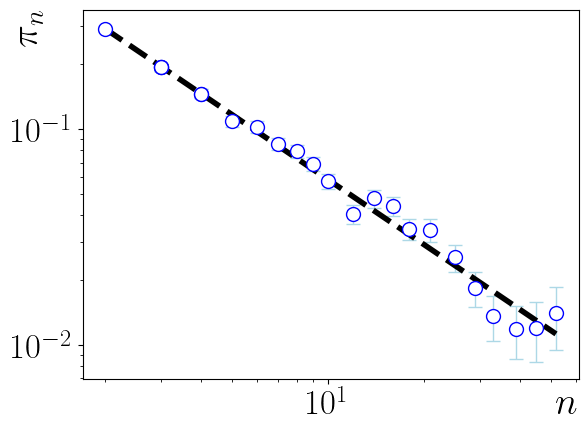

In [6]:
H=0.67

T=[]
Max=0

epochs=50

print(len(P))
print(len(P[0]))
for m in range(epochs-1): 
  for k in range(len(P)): #for each trajectory
    window=len(P[k])//epochs
    print(window)
    #print(window)
    Size=Splitt(P[k][window*m:])
    T.append(Size[:])
    Max=max(len(Size),Max)
    
Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]
fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)

A = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])[0][0]
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,n[Ind])

plt.semilogx()
plt.semilogy()

# ax.text(3, 0.01, rf'Amoeba', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='top')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Amoeba.pdf', dpi=600, bbox_inches='tight')

# Ethernet cumulative traffic
See more on this dataset in Nature Commun paper records

999999


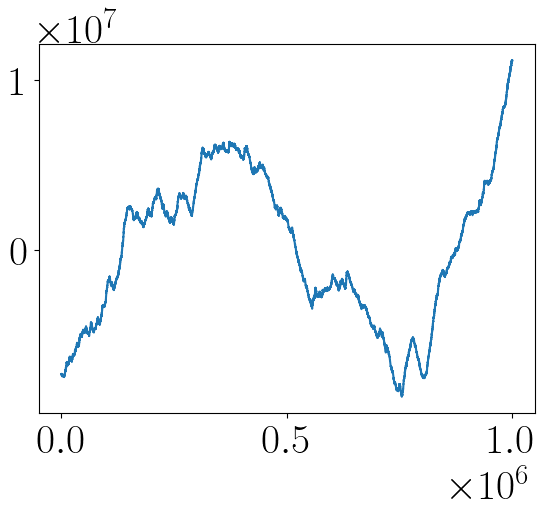

In [244]:
H=0.81


l=pd.read_csv('Data/BC-pAug89.csv')
Dates=[]
Values=[]

def sep(l):
    s1,s2='',''
    k=0
    while l[k]==' ':
        k+=1
    while l[k]!=' ':
        s1+=l[k]
        k+=1
    while l[k]==' ':
        k+=1
    while l[k]!=' ':
        s2+=l[k]
        k+=1
    return s1,s2

u=0
for k in l:
    for i in range(len(l[k])):
        s1,s2=sep(l[k][i])
        Dates.append(float(s1))
        Values.append(int(s2))
    u+=1

    
Values=np.cumsum(Values)
X=np.arange(len(Values))


a,b=curve_fit(modlin,X,Values)[0]

Values=Values-modlin(X,a,b)    
    


plt.plot(Values)
P=Values
print(len(Values))

In [245]:
T=[]
Max=0

T=[]
epochs=3000
print(len(Values)//epochs)
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    print(k)
    Size=Splitt(Values[k*window:])
    Max=max(len(Size),Max)
    T.append(Size[:])

    Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1



333
333
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

[0.33807097] [[0.0006102]]


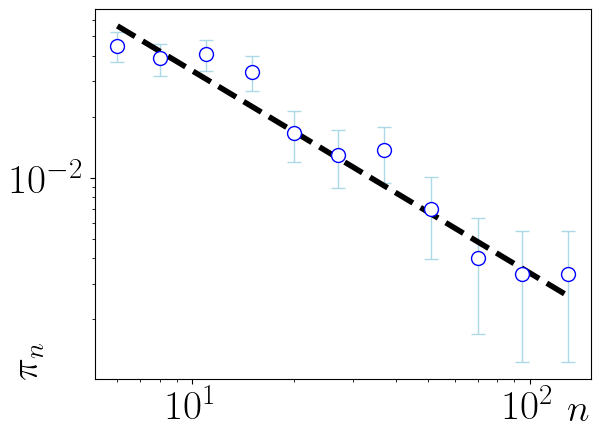

In [249]:
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.75,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]

fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A,var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,var)
plt.semilogx()
plt.semilogy()

# ax.text(3, 0.005, rf'Single cell P1', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='bottom')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
from matplotlib.ticker import LogLocator, LogFormatter,LogFormatterMathtext


ax.set_xscale('log')
ax.set_yscale('log')
# Major ticks at decades only
ax.xaxis.set_major_locator(LogLocator(base=10.0))  
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0, labelOnlyBase=True))

# Minor ticks (keep them unlabeled)
# ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 18)))
ax.xaxis.set_minor_formatter(lambda *_: "")

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Ethernet.pdf', dpi=600, bbox_inches='tight')

# Single cell patient 1
Data from the following paper https://www.nature.com/articles/s42003-020-01605-w#Sec18. They have 12 patients of different ages for which they study the motility of their cells.

[  0  81  80  68  30  68 105  91  96  69  51  60  61]


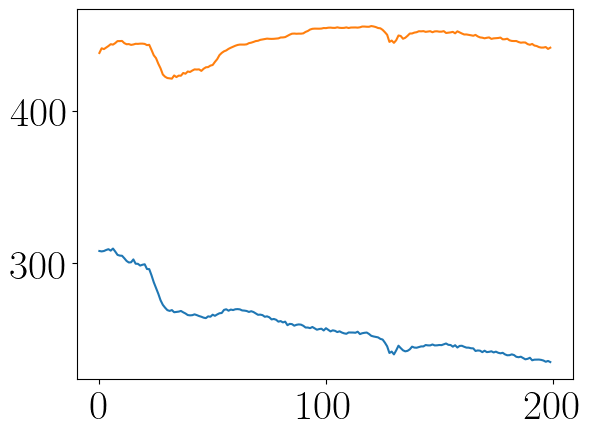

In [8]:
TRAJ=[]
L=np.loadtxt('Data/42003_2020_1605_MOESM5_ESM.txt')
Ncells=np.arange(13)*0
Ncells[1]+=1

for k in range(1,len(L)):
    if L[k][1]!=L[k-1][1]:
        Ncells[np.int64(L[k][0])]+=1
print(Ncells)

Seen=0
for m in range(1,13):
    Traj=[]
    for k in range(Ncells[m]):
        Traj.append([])
        Traj.append([])
        for l in range(200):
            Traj[-1].append(L[Seen+k*200+l][-1])
            Traj[-2].append(L[Seen+k*200+l][-2])
            #if np.abs(L[Seen+k*200+l][-1]-L[Seen+k*200+l-1][-1])>10:
                #print(Seen+k*200+l)
        #Traj[-1]=np.array(Traj[-1])-np.mean(np.array(Traj[-1][1:])-np.array(Traj[-1][:-1]))*np.arange(len(Traj[-1]))
        #Traj[-2]=np.array(Traj[-2])-np.mean(np.array(Traj[-2][1:])-np.array(Traj[-2][:-1]))*np.arange(len(Traj[-2]))
    Seen+=Ncells[m]*200
    TRAJ.append(Traj[:])

    
Patient=0
Trajindex=10
plt.plot(TRAJ[Patient][Trajindex])
plt.plot(TRAJ[Patient][Trajindex+1])

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
2

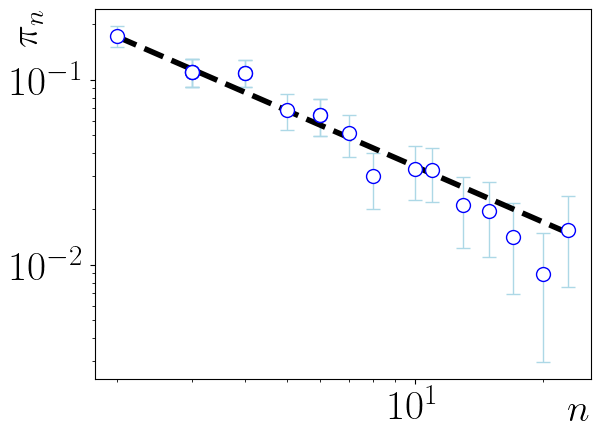

In [10]:
Traj=np.array(TRAJ[0])
T=[]
Max=0

epochs=8
# print(len(Traj))
# print(len(Traj[0]))

for m in range(epochs-1): 
  for k in range(len(Traj)):
    window=len(Traj[k])//epochs
    print(window)
    Size=Splitt(Traj[k][window*m:])
    T.append(Size[:])
    Max=max(len(Size),Max)
    
Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>yerr[Ind]*1.5]

fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])[0][0]
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A)
plt.semilogx()
plt.semilogy()

# ax.text(3, 0.005, rf'Single cell P1', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='top')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
from matplotlib.ticker import LogLocator, LogFormatter,LogFormatterMathtext


ax.set_xscale('log')
ax.set_yscale('log')
# Major ticks at decades only
ax.xaxis.set_major_locator(LogLocator(base=10.0))  
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0, labelOnlyBase=True))

# Minor ticks (keep them unlabeled)
# ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 18)))
ax.xaxis.set_minor_formatter(lambda *_: "")

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/CellP1.pdf', dpi=600, bbox_inches='tight')

# Single cell patient 12
Data from the following paper https://www.nature.com/articles/s42003-020-01605-w#Sec18. They have 12 patients of different ages for which they study the motility of their cells.

122
200
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18

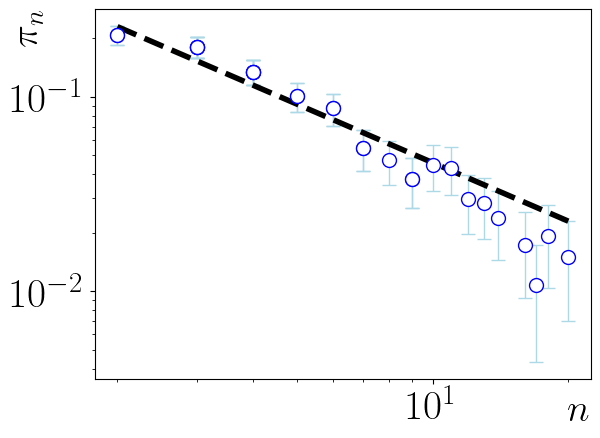

In [243]:
T=[]
Max=0

Traj=np.array(TRAJ[11])
epochs=11
print(len(Traj))
print(len(Traj[0]))

for m in range(epochs-1): 
  for k in range(len(Traj)):
    window=len(Traj[k])//epochs
    print(window)
    Size=Splitt(Traj[k][window*m:])
    T.append(Size[:])
    Max=max(len(Size),Max)
    
Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,50))
Ind=Ind[p[Ind]>yerr[Ind]*1.5]

print(n[Ind])

fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])[0][0]
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A)

# plt.semilogx()
plt.semilogy()

# ax.text(3, 0.01, rf'Single cell P2', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='top')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
from matplotlib.ticker import LogLocator, LogFormatter,LogFormatterMathtext


ax.set_xscale('log')
ax.set_yscale('log')
# Major ticks at decades only
#ax.xaxis.set_major_locator(LogLocator(base=10.0))  
# ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0, labelOnlyBase=True))

# Minor ticks (keep them unlabeled)
# ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 17)))
ax.xaxis.set_minor_formatter(lambda *_: "")


plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/CellP12.pdf', dpi=600, bbox_inches='tight')

# SPX index
Classical financial data to analyze. Are downloadable on yahoo finance. Can update the date up to which you download the data.
IMPORTANT : $n$ is the number of distinct level prices. After logarithmic transform to suppress the exponential drift, $n$ is STILL the number of distinct log-indices. But $n$ cannot be interpreted as the 'size' of the visited interval.

[*********************100%***********************]  1 of 1 completed

[1.56525734 1.56133992 1.55047296 ... 3.77815341 3.77917136 3.77843924]
0.0001203864111254908 1.4966885610233347


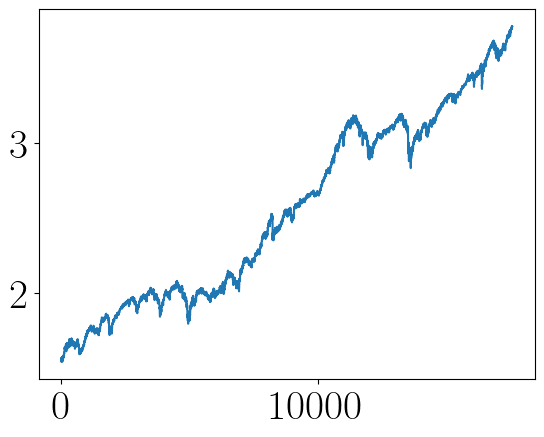

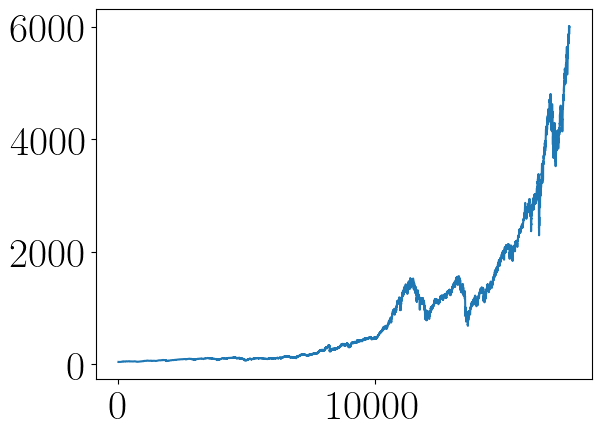

In [225]:
data = yf.download(tickers = "^GSPC", start = "1955-01-01", 
                              end = "2024-11-30", interval = "1d",auto_adjust=True)
data=np.array(data['Open'])
# print(data)


Values=np.array([np.log10(data[k][0]) for k in range(len(data))])
Valuesexp=np.array([data[k][0] for k in range(len(data))])
X=np.arange(len(Values))

print(Values)
a,b=curve_fit(modlin,X,Values)[0]
print(a,b)

# Values=Values-modlin(X,a,b)
# Values = np.diff(Values, 1)
plt.plot(Values)
plt.show()
plt.plot(Valuesexp)
plt.show()

17
window=17
1000
[0.5957434] [[0.00128881]]


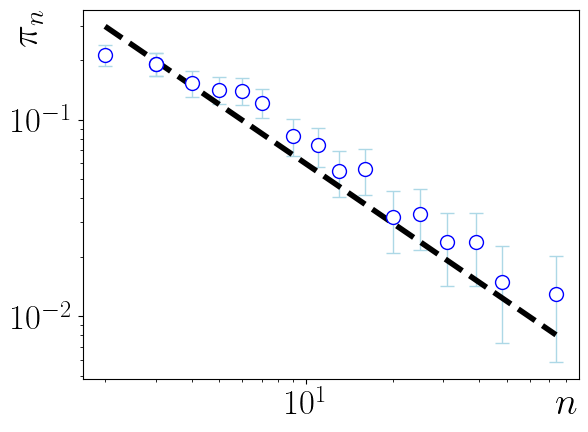

In [227]:
T=[]
Max=0
Values = Values
T=[]
epochs=1000
print(len(Values)//epochs)
window=len(Values)//epochs
print(f"window={window}")
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
   
    Max=max(len(Size),Max)
    # print(len(Size[:]))
    T.append(Size[:])

Pi_n=np.zeros(Max)
C_n=np.zeros(Max)
print(f"{len(T)}")

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]


fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A, var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,var)

plt.semilogx()
plt.semilogy()

# ax.text(3, 0.05, rf'SPX Index', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='top')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='right')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/SPX.pdf', dpi=600, bbox_inches='tight')

# N225
Classical financial data to analyze. Are downloadable on yahoo finance. Can update the date up to which you download the data.

[*********************100%***********************]  1 of 1 completed

6.76616173633594e-05 3.519013442360223


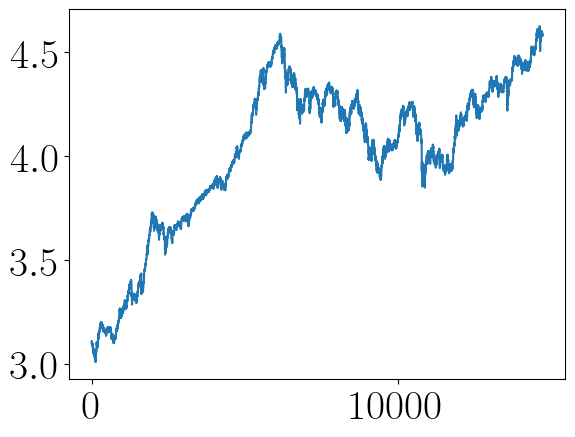

In [221]:
data = yf.download("^N225", start="1955-01-01", end="2024-11-30",interval="1d")
data=np.array(data['Open'])


Values=np.array([np.log10(data[k][0]) for k in range(len(data))])
X=np.arange(len(Values))


a,b=curve_fit(modlin,X,Values)[0]
print(a,b)
a,b=0,0


Values=Values-modlin(X,a,b)
plt.plot(Values)

14
14
[0.64379038] [[0.00055199]]


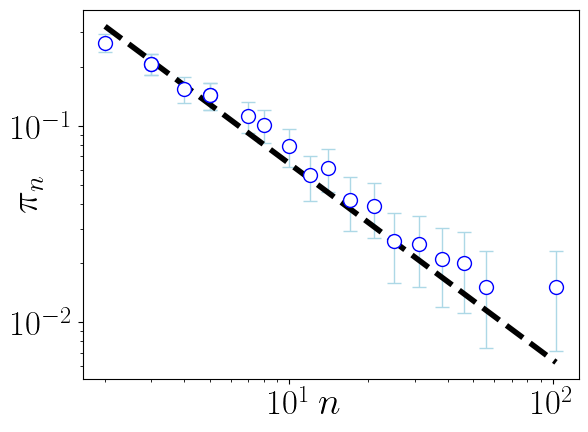

In [222]:
T=[]
Max=0
Values=Values
T=[]
epochs=1000
print(len(Values)//epochs)
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
    Max=max(len(Size),Max)
    T.append(Size[:])

    Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]


fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A, var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,var)

plt.semilogx()
plt.semilogy()

# ax.text(5, .3, rf'N225 Index', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='center')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/N225.pdf', dpi=600, bbox_inches='tight')

# DowJones

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

0.00011250541388162345 3.6202767424935676


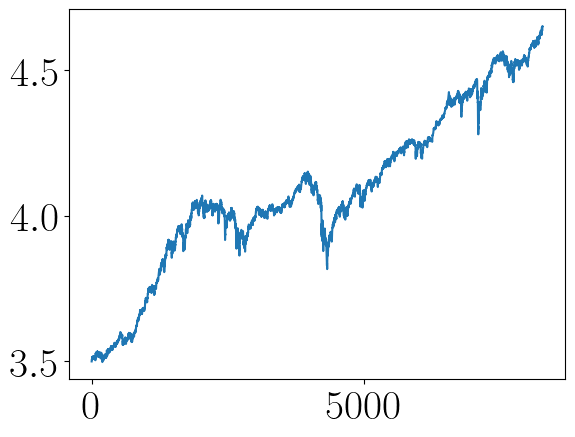

In [2]:
data = yf.download("^DJI", start="1955-01-01", end="2024-11-30",interval="1d")
data=np.array(data['Open'])


Values=np.array([np.log10(data[k][0]) for k in range(len(data))])
X=np.arange(len(Values))


a,b=curve_fit(modlin,X,Values)[0]
print(a,b)
a,b=0,0


Values=Values-modlin(X,a,b)
plt.plot(Values)

82
[0.60573427] [[0.00197961]]


(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

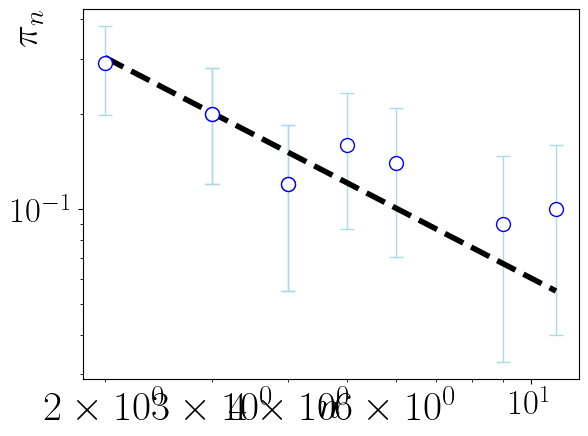

In [ ]:
T=[]
Max=0
# Values=Values[::2]
T=[]
epochs=1000
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
    Max=max(len(Size),Max)
    T.append(Size[:])

    Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(1,Max+1)
Ind=np.int64(np.logspace(.25,np.log10(Max)-.1,30))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]


fig, ax = plt.subplots(1, 1)
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A, var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,var)

plt.semilogx()
plt.semilogy()

# ax.text(3, 0.03, rf'Dow-Jones Index', fontsize=22)

plt.ylabel(r'$\pi_n$',fontsize=28,labelpad=-25,loc='top')
plt.xlabel(r'$n$',fontsize=28,labelpad=-25,loc='center')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/DowJones.pdf', dpi=600, bbox_inches='tight')

# BONUS: study of scale invariance for Single cell patients

[  0  81  80  68  30  68 105  91  96  69  51  60  61]
0.7883214850155082


C:\Users\julie\AppData\Local\Temp\ipykernel_404\3081470951.py:86: RuntimeWarning: divide by zero encountered in log10
  x,y=np.log10(n_lis)[5:],np.log10(Sig)[5:]


Text(0, 0.5, '$F(\\ell) $')

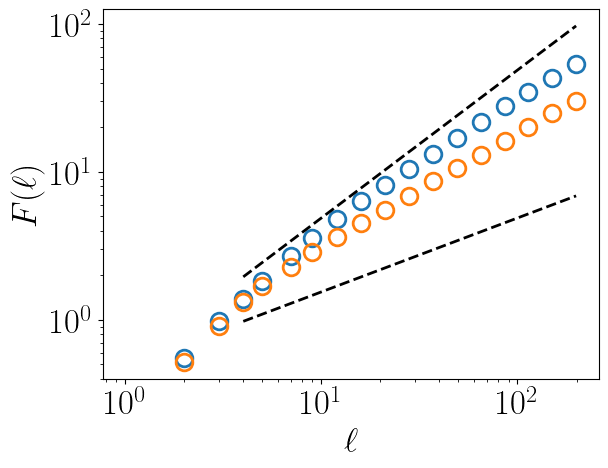

In [369]:
TRAJ=[]
L=np.loadtxt('Data/42003_2020_1605_MOESM5_ESM.txt')
Ncells=np.arange(13)*0
Ncells[1]+=1

for k in range(1,len(L)):
    if L[k][1]!=L[k-1][1]:
        Ncells[np.int64(L[k][0])]+=1
print(Ncells)

Seen=0
for m in range(1,13):
    Traj=[]
    for k in range(Ncells[m]):
        Traj.append([])
        Traj.append([])
        for l in range(200):
            Traj[-1].append(L[Seen+k*200+l][-1])
            Traj[-2].append(L[Seen+k*200+l][-2])
            #if np.abs(L[Seen+k*200+l][-1]-L[Seen+k*200+l-1][-1])>10:
                #print(Seen+k*200+l)
        #Traj[-1]=np.array(Traj[-1])-np.mean(np.array(Traj[-1][1:])-np.array(Traj[-1][:-1]))*np.arange(len(Traj[-1]))
        #Traj[-2]=np.array(Traj[-2])-np.mean(np.array(Traj[-2][1:])-np.array(Traj[-2][:-1]))*np.arange(len(Traj[-2]))
    Seen+=Ncells[m]*200
    TRAJ.append(Traj[:])

n_lis=np.int64(np.logspace(0,np.log10(200-1),20))
n_max=max(n_lis)

Traj=TRAJ[0]
def sig_n(y,n):
    N=len(y)
    y_n=[]
    for t in range(n_max,N,10):
       y_n.append(np.mean(y[t-n+1:t+1])) 
    y_n=np.array(y_n)
    return (np.sum((y[n_max::10]-y_n)**2),len(y_n))


SIG=np.zeros(len(n_lis))
YL=np.zeros(len(n_lis))
for k in range(len(Traj)):
  for i in range(len(n_lis)):
     n=n_lis[i]
     s,l= sig_n(Traj[k],n)
     SIG[i]+=s
     YL[i]+=l   
Sig=np.sqrt(SIG/YL)



plt.plot(n_lis,Sig,'o',markersize=12,linestyle='',fillstyle='none',linewidth=20,markeredgewidth=2.0)



n_lis=np.int64(np.logspace(0,np.log10(200-1),20))
n_max=max(n_lis)

Traj=TRAJ[11]
def sig_n(y,n):
    N=len(y)
    y_n=[]
    for t in range(n_max,N,10):
       y_n.append(np.mean(y[t-n+1:t+1])) 
    y_n=np.array(y_n)
    return (np.sum((y[n_max::10]-y_n)**2),len(y_n))


SIG=np.zeros(len(n_lis))
YL=np.zeros(len(n_lis))
for k in range(len(Traj)):
  for i in range(len(n_lis)):
     n=n_lis[i]
     s,l= sig_n(Traj[k],n)
     SIG[i]+=s
     YL[i]+=l   
Sig=np.sqrt(SIG/YL)



plt.plot(n_lis,Sig,'o',markersize=12,linestyle='',fillstyle='none',linewidth=20,markeredgewidth=2.0)




x,y=np.log10(n_lis)[5:],np.log10(Sig)[5:]
sol=curve_fit(modlin,x,y)
a,b=sol[0]
print(a)
plt.plot(10**x,10**modlin(x,1,b),'--k',linewidth=2)
plt.plot(10**x,10**modlin(x,1/2,b),'--k',linewidth=2)
plt.semilogx()
plt.semilogy()

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$\ell$',fontsize=25)
plt.ylabel(r'$F(\ell) $',fontsize=25)




# BONUS: telomere data
See paper Nature Comm, data given by someone to thank for (see Ref 26),  D. Krapf, M. Weiss, F. Taheri and
C. Selhuber-Unkel. However, as H=0.25 is small, it is hard to have a large number $n$ of visited sites (statistics is not incredible).

2000


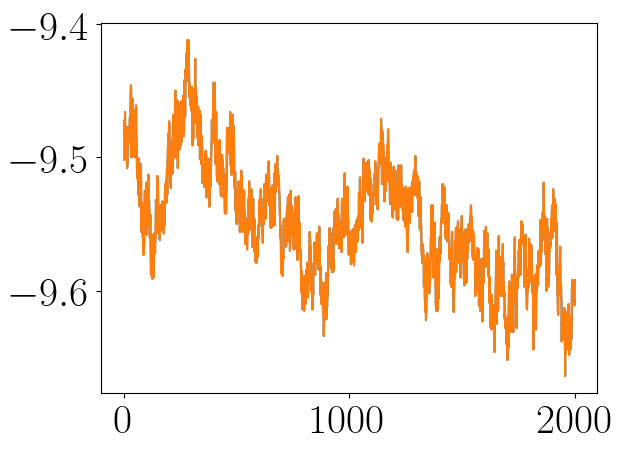

In [261]:
px=np.loadtxt('Data/telomers_xx.dat')
py=np.loadtxt('Data/telomers_yy.dat')

Values=px[0]
Dates=np.arange(1,len(Values)+1)

plt.plot(Values)

P=[]

H=0.5
for l in range(len(px)):
        T=np.int64(np.logspace(0.5,3,10))
        X2=np.zeros(len(T))
        Values=px[l]  
        for i in range(len(T)):
            k=T[i]
            Tk=[]
            for u in range(0,len(Values)-k):
                  Tk.append((Values[k+u]-Values[u])**2)
            X2[i]=np.mean(Tk)
        sol=curve_fit(modlin,np.log10(T),np.log10(X2))
        if abs(sol[0][0]-H)<0.05:
            P.append(np.array(px[l]))
 
        

for l in range(len(py)):
        T=np.int64(np.logspace(0.5,3,20))
        X2=np.zeros(len(T))
        Values=py[l]  
        for i in range(len(T)):
            k=T[i]
            Tk=[]
            for u in range(0,len(Values)-k):
                  Tk.append((Values[k+u]-Values[u])**2)
            X2[i]=np.mean(Tk)
        sol=curve_fit(modlin,np.log10(T),np.log10(X2))
        if abs(sol[0][0]-H)<0.05:
            P.append(np.array(py[l]))
 
print(P[0].size)
plt.plot(P[0])
plt.show()

1
1
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40]
[1.84131866] [[0.00063208]] [ 5  5  5  5  5  5  5  6  6  6  6  6  6  6  7  7  7  7  8  8  8  9  9  9
 10 10 11 11 12 12 13 13 14 15 16 16 17 18 19 20 21 23 24 25 27 28 30]


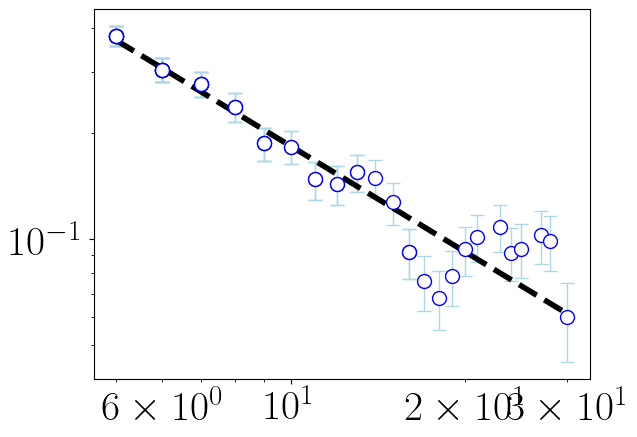

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

fig, ax = plt.subplots(1, 1)

T=[]
Max=0
Values=P[0]

epochs=1500
print(len(Values)//epochs)
window=len(Values)//epochs
print(window)
for k in range(0,epochs):
    Size=Splitt(Values[k*window:])
    Max=max(len(Size),Max)
    T.append(Size[:])

    Pi_n=np.zeros(Max)
C_n=np.zeros(Max)

for t in T:
    for k in range(len(t)):
        Pi_n[k]+=t[k]
        C_n[k]+=1
p=Pi_n/C_n 
yerr=np.sqrt(p*(1-p)/C_n)*2
n=np.arange(4,Max)
Ind=np.int64(np.logspace(0.1,np.log10(Max)-.1,50))
Ind=Ind[p[Ind]>1.5*yerr[Ind]]
print(n)

# Main errorbar plot
plt.errorbar(n[Ind],p[Ind],yerr=yerr[Ind], fmt='o',                  # Circle marker only
    color='blue',
    ecolor='lightblue',            # Error bar color
    elinewidth=1,
    capsize=5,
    markersize=10,
    markerfacecolor='white',  # Hollow markers
    markeredgewidth=1)
A, var = curve_fit(finv, n[Ind], p[Ind], sigma=yerr[Ind])
plt.plot(n[Ind],A/n[Ind],'--k',linewidth=4)
print(A,var,n[Ind])

from matplotlib.ticker import LogLocator, LogFormatter,LogFormatterMathtext

ax.set_xscale('log')
ax.set_yscale('log')
# Major ticks at decades only
# ax.xaxis.set_major_locator(LogLocator(base=10.0))  
# ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0, labelOnlyBase=True))

plt.savefig('C:/Users/julie/Nextcloud/These/Data/persistence in exploration/Figures/Telomere.pdf', dpi=600, bbox_inches='tight')
plt.show()


